In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from scipy.stats import skellam,poisson
import tqdm


In [135]:
class jacksCarRentals:
    def __init__(self):
        self.carsInEachLocation = np.array([10,10])
        self.isTerminated =False
    

    def interact(self,numberOfCarsToMove):
        if self.isTerminated :
            return 0, True


        self.carsInEachLocation[0] -= numberOfCarsToMove
        self.carsInEachLocation[1] += numberOfCarsToMove
        
        requestedCars = np.random.poisson([3,4])
        returnedCars = np.random.poisson([3,2])


        self.carsInEachLocation += returnedCars - requestedCars
        self.carsInEachLocation = np.where(self.carsInEachLocation > 20,20,self.carsInEachLocation)
        if any(self.carsInEachLocation < 0):
           self. isTerminated = True
        
        reward = np.sum(requestedCars)* 10 - numberOfCarsToMove*2
        return reward, self.isTerminated
        
        

In [222]:

class Agent:
    def __init__(self):
        self.vValues = np.zeros((21,21),np.float)
        self.policy = np.zeros((21,21),np.int)
        self.diff1Dist = skellam(3,3)
        self.diff2Dist = skellam(2,4)

        self.expectedRewards = np.empty([21,21,11])
        for i in range(self.vValues.shape[0]):
            for j in range(self.vValues.shape[1]): 
                for a in range(-5,6):
                    self.expectedRewards[i,j,a+5] = (poisson(3).pmf(np.arange(i+1)) * np.arange(i+1)).sum() / poisson(3).cdf((i+1))
                    + (poisson(4).pmf(np.arange(j+1)) * np.arange(j+1)).sum() / poisson(3).cdf((i+1))
                    - 2*abs(a)



    def generateProbs(self,s,a):
        i,j = s
        A = self.diff1Dist.pmf(np.arange(21)-i+a)
        A[19] += 1-self.diff1Dist.cdf(20-i+a) 
        B = self.diff2Dist.pmf(np.arange(21)-j-a)
        B[19] += 1-self.diff2Dist.cdf(20-j-a) 

        return A.reshape(-1,1) @ B.reshape(1,-1)

        
    def evaluatePolicy(self,iterations = 10):


        for _ in range(iterations):
            for i in range(self.vValues.shape[0]):
                for j in range(self.vValues.shape[1]):
                    a = self.policy[i,j]

                    probs = self.generateProbs([i,j],a)
                    self.vValues[i,j] = np.sum( self.vValues * probs ) * 0.9 + self.expectedRewards[i,j,a+5]
                        
            
    def policyItration(self):
        Diff1 = skellam(3,3)
        Diff2 = skellam(2,4)
        
        for i in range(self.vValues.shape[0]):
            for j in range(self.vValues.shape[1]):

                neighborValues = []
                vs = []
                for a in range(-5,6):

                    probs = self.generateProbs([i,j],a)
                    vs.append( np.sum(self.vValues * probs)* 0.9 + self.expectedRewards[i,j,a+5])

                self.policy[i,j] = np.argmax(vs)-5
                    

In [223]:
ag = Agent()

In [226]:
ag.evaluatePolicy(5)
ag.policyItration()


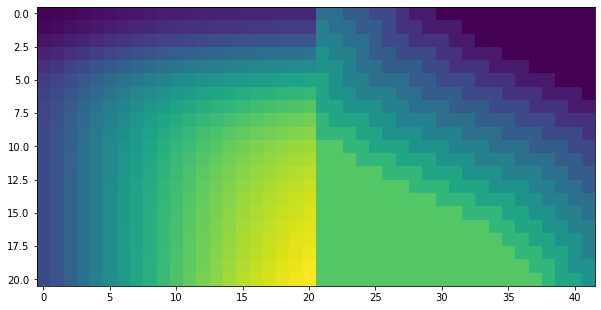

In [225]:
plt.figure(figsize=[10,10])
plt.imshow(np.concatenate([ag.vValues,(ag.policy+5)*ag.vValues.mean()/7],1))


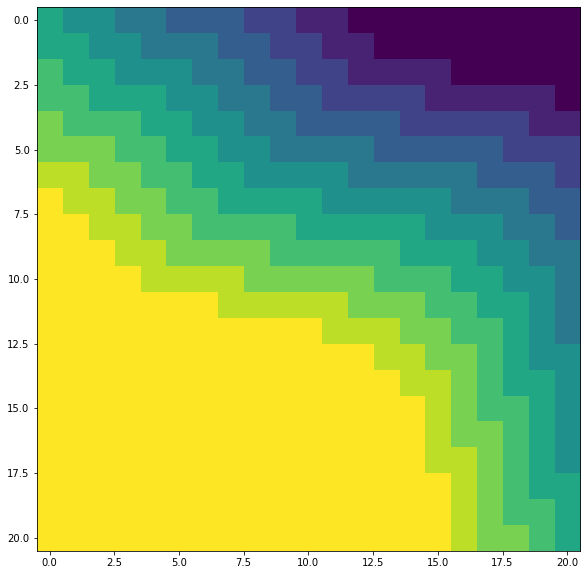

In [187]:
plt.figure(figsize=[10,10])
plt.imshow(ag.policy)

In [188]:
meanRew = 0
for i in tqdm.trange(10000):
    env = jacksCarRentals()
    rew = 0
    for _ in range(100):
        a = ag.policy[env.carsInEachLocation[0],env.carsInEachLocation[1]]
        # print(env.carsInEachLocation,a)
        r, t = env.interact(a)
        if t:
            break
        rew+=r
    meanRew = meanRew*(1-1/(i+1)) + rew/(i+1)
meanRew

100%|██████████| 10000/10000 [00:08<00:00, 1247.62it/s]


588.6708000000009